In [90]:
import numpy as np
import pandas as pd
import string
from math import sqrt
from jupyterthemes import jtplot
jtplot.style()

### The goal of this assignment is to implement your own logistic regression classifier with L2 regularization. You will do the following:
#### Extract features from Amazon product reviews.
#### Convert an dataframe into a NumPy array.
#### Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
#### Implement gradient ascent with an L2 penalty.
#### Empirically explore how the L2 penalty can ameliorate overfitting.

#### 1. For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews. Load the dataset into a data frame named products.

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')

In [4]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


#### If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the review columns as follows:

In [5]:
np.sum(pd.isna(products['review']))

241

In [6]:
products = products.fillna({'review': ''})

In [7]:
np.sum(pd.isna(products['review']))

0

#### Write a function remove_punctuation that takes a line of text and removes all punctuation from that text. The function should be analogous to the following Python code:

In [8]:
def remove_punctuation(text):
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)

#### Apply the remove_punctuation function on every element of the review column and assign the result to the new column review_clean. Note. Many data frame packages support apply operation for this type of task. Consult appropriate manuals.

In [9]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [10]:
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


#### Now we proceed with the second item. For each word in important_words, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in important_words which keeps a count of the number of times the respective word occurs in the review text.

In [11]:
important_words = pd.read_json('important_words.json')

In [12]:
important_words.head()

,0
0,baby
1,one
2,great
3,love
4,use


In [13]:
important_words_list = important_words[0].tolist()

In [14]:
important_words_list

['baby',
 'one',
 'great',
 'love',
 'use',
 'would',
 'like',
 'easy',
 'little',
 'seat',
 'old',
 'well',
 'get',
 'also',
 'really',
 'son',
 'time',
 'bought',
 'product',
 'good',
 'daughter',
 'much',
 'loves',
 'stroller',
 'put',
 'months',
 'car',
 'still',
 'back',
 'used',
 'recommend',
 'first',
 'even',
 'perfect',
 'nice',
 'bag',
 'two',
 'using',
 'got',
 'fit',
 'around',
 'diaper',
 'enough',
 'month',
 'price',
 'go',
 'could',
 'soft',
 'since',
 'buy',
 'room',
 'works',
 'made',
 'child',
 'keep',
 'size',
 'small',
 'need',
 'year',
 'big',
 'make',
 'take',
 'easily',
 'think',
 'crib',
 'clean',
 'way',
 'quality',
 'thing',
 'better',
 'without',
 'set',
 'new',
 'every',
 'cute',
 'best',
 'bottles',
 'work',
 'purchased',
 'right',
 'lot',
 'side',
 'happy',
 'comfortable',
 'toy',
 'able',
 'kids',
 'bit',
 'night',
 'long',
 'fits',
 'see',
 'us',
 'another',
 'play',
 'day',
 'money',
 'monitor',
 'tried',
 'thought',
 'never',
 'item',
 'hard',
 'plasti

In [15]:
products['review_clean'][0].split().count('of')

1

#### After #2 and #3, the data frame products should contain one column for each of the 193 important_words. As an example, the column perfect contains a count of the number of times the word prefect occurs in each of the reviews.

In [16]:
for item in important_words_list:
    products[item] = products['review_clean'].apply(lambda x: x.split().count(item))

### Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use seed=2 so that everyone gets the same result. Call the training and validation sets train_data and validation_data, respectively.

Note: In previous assignments, we have called this a train-test split. However, the portion of data that we don't train on will be used to help select model parameters (this is known as model selection). Thus, this portion of data should be called a validation set. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [17]:
trainidx = pd.read_json('module-4-assignment-train-idx.json')
valididx = pd.read_json('module-4-assignment-validation-idx.json')

In [18]:
train_data = products.iloc[trainidx[0].tolist()]

In [19]:
validation_data = products.iloc[valididx[0].tolist()]

In [29]:
train_data.columns

Index(['name', 'review', 'rating', 'sentiment', 'review_clean', 'baby', 'one',
       'great', 'love', 'use',
       ...
       'picture', 'completely', 'wish', 'buying', 'babies', 'won', 'tub',
       'almost', 'either', 'constant'],
      dtype='object', length=199)

### Convert data frame to multi-dimensional array

Convert train_data and validation_data into multi-dimensional arrays.

Using the function given in #8 of Module 3 assignment, extract two arrays feature_matrix_train and sentiment_train from train_data. The 2D array feature_matrix_train would contain the content of the columns given by the list important_words. The 1D array sentiment_train would contain the content of the column sentiment. Do the same for validation_data, producing the arrays feature_matrix_valid and sentiment_valid. The code should be analogous to this cell:

In [21]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    """
        products.head()[['name', 'rating']].values == products.head().as_matrix(columns=['name', 'rating'])
        use as_matrix() function 
        can also use df.values function 
        https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array-preserving-index
        https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.as_matrix.html
    
    """
    feature_matrix = dataframe.as_matrix(columns=features)
    label_array = dataframe.as_matrix(columns=[label])
    
    return feature_matrix, label_array

In [22]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words_list, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words_list, 'sentiment') 

f:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Building on logistic regression with no L2 penalty assignment

Let us now build on the assignment of the previous module. Recall from lecture that the link function for logistic regression can be defined as:
P(yi=+1|xi,w)=11+exp(−wTh(xi)) where the feature vector h(x_i)
is given by the word counts of important_words in the review \mathbf{x}_ix 
We will use the same code as in this past assignment to make probability predictions since this part is not affected by the L2 penalty. (Only the way in which the coefficients are learned is affected by the addition of a regularization term.) Refer to #10 of Module 3 assignment in order to obtain the function predict_probability.

In [23]:
def predict_probability(feature_matrix, coefficients):
    '''
        produces probablistic estimate for P(y_i = +1 | x_i, w).
        estimate ranges between 0 and 1.
    '''
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    # score is len(feature_matrix) * 1  vector
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    # predictions is len(feature_matrix) * 1  vector
    predictions = 1 / (1 + np.exp(-score))
    
    # return predictions
    return predictions

### Adding L2 penalty
Let us now work on extending logistic regression with an L2 penalty. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log-likelihood function is:
Write a function that computes the derivative of log likelihood with respect to a single coefficient w_j. Unlike its counterpart in the last assignment, the function accepts five parameters:
The function should do the following:
Take the five parameters as above. Compute the dot product of errors and feature and save the result to derivative. If feature_is_constant is False, subtract the L2 penalty term from derivative. Otherwise, do nothing. Return derivative.

In [25]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE small confusion, why this order? 
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2 * l2_penalty * coefficient
        
    return derivative

In [44]:
np.dot([1, 2, 3], [2, 3, 4])

20

### 10. To verify the correctness of the gradient descent algorithm, we write a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability), which is given by the formula

In [39]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penaltyl2_penalty):

    # indicator is a vector
    indicator = (sentiment == 1).reshape(len(sentiment), )

    # socres is also a vector, each element is the score of each obervation
    scores = np.dot(feature_matrix, coefficients)

    # lp is scalar of the total dataset
    lp = np.sum((indicator - 1) * scores - np.log(1. + np.exp(-scores))
                ) - l2_penalty * np.sum(coefficients[1:]**2)

    return lp

### The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.
Write a function logistic_regression_with_L2 to fit a logistic regression model under L2 regularization.
The function accepts the following parameters:
feature_matrix: 2D array of features sentiment: 1D array of class labels initial_coefficients: 1D array containing initial values of coefficients step_size: a parameter controlling the size of the gradient steps l2_penalty: the L2 penalty constant λ max_iter: number of iterations to run gradient ascent The function returns the last set of coefficients after performing gradient ascent.

The function carries out the following steps:
Initialize vector coefficients to initial_coefficients. Predict the class probability P(y_i = +1 | x_i,w) using your predict_probability function and save it to variable predictions. Compute indicator value for (y_i = +1) by comparing sentiment against +1. Save it to variable indicator. Compute the errors as difference between indicator and predictions. Save the errors to variable errors. For each j-th coefficient, compute the per-coefficient derivative by calling feature_derivative_L2 with the j-th column of feature_matrix. Don't forget to supply the L2 penalty. Then increment the j-th coefficient by (step_size*derivative). Once in a while, insert code to print out the log likelihood. Repeat steps 2-6 for max_iter times.

In [40]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1).reshape(len(sentiment),)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], 
                                                   l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

### Explore effects of L2 regularization
Now that we have written up all the pieces needed for an L2 solver with logistic regression, let's explore the benefits of using L2 regularization while analyzing sentiment for product reviews. As iterations pass, the log likelihood should increase.
Let us train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation. Train 6 models with L2 penalty values 0, 4, 10, 1e2, 1e3, and 1e5. Use the following values for the other parameters:
feature_matrix = feature_matrix_train extracted in #7 sentiment = sentiment_train extracted in #7 initial_coefficients = a 194-dimensional vector filled with zeros step_size = 5e-6 max_iter = 501 Save the 6 sets of coefficients as coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, and coefficients_1e5_penalty respectively.

In [41]:
L2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]

In [42]:
feature_matrix = feature_matrix_train
sentiment = sentiment_train 
initial_coefficients = np.zeros(194)
step_size = 5e-6
max_iter = 501

In [43]:
coefficients_list = [logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, 
  step_size, l2_penalty, max_iter) for l2_penalty in L2_penalty_list]

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.42422295
iteration  15: log likelihood of observed labels = -27379.97375625
iteration  20: log likelihood of observed labels = -27027.18208317
iteration  30: log likelihood of observed labels = -26527.22737267
iteration  40: log likelihood of observed labels = -26206.59048765
iteration  50: log likelihood of observed labels = -25995.96903148
iteration  60: log likelihood of observed labels = -25854.95710284
iteration  70: log likelihood of observed labels = -25759.0810

In [46]:
len(coefficients_list)

6

In [48]:
coefficients_0_penalty = coefficients_list[0]
coefficients_4_penalty = coefficients_list[1]
coefficients_10_penalty = coefficients_list[2]
coefficients_1e2_penalty = coefficients_list[3]
coefficients_1e3_penalty = coefficients_list[4]
coefficients_1e5_penalty = coefficients_list[5]

### Compare coefficients

We now compare the coefficients for each of the models that were trained above. Create a table of features and learned coefficients associated with each of the different L2 penalty values.

Using the coefficients trained with L2 penalty 0, find the 5 most positive words (with largest positive coefficients). Save them to positive_words. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to negative_words.

Quiz Question. Which of the following is not listed in either positive_words or negative_words?
Let us observe the effect of increasing L2 penalty on the 10 words just selected. Make a plot of the coefficients for the 10 words over the different values of L2 penalty.

In [60]:
df_0 = pd.DataFrame(data=coefficients_0_penalty[1:], columns=['Coef'])
df_0['Word'] = important_words_list
df_0.sort_values('Coef', ascending=False).head(5)

,Coef,Word
3,1.058554,love
22,1.052484,loves
7,0.984559,easy
33,0.835693,perfect
2,0.801625,great


In [61]:
df_0.sort_values('Coef', ascending=True).head(5)

,Coef,Word
105,-0.955437,disappointed
96,-0.768793,money
113,-0.742085,return
112,-0.617809,waste
168,-0.572707,returned


In [64]:
Words = df_0.sort_values('Coef', ascending=True).head(5)['Word'].tolist() + df_0.sort_values('Coef', ascending=False).head(5)['Word'].tolist()

In [68]:
negative_words = Words[:5]

In [69]:
positive_words = Words[5:]

In [70]:
negative_words

['disappointed', 'money', 'return', 'waste', 'returned']

In [71]:
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [106]:
df = pd.DataFrame([coefficients_0_penalty, coefficients_4_penalty,
                   coefficients_10_penalty, coefficients_1e2_penalty, 
                   coefficients_1e3_penalty, coefficients_1e5_penalty]).T

In [107]:
df['word'] = ['intercept'] + important_words_list

In [108]:
df

,0,1,2,3,4,5,word
0,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362,intercept
1,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784,baby
2,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827,one
3,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950,great
4,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042,love
5,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418,use
6,-0.287021,-0.286027,-0.284564,-0.265993,-0.188662,-0.008127,would
7,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827,like
8,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808,easy
9,0.524419,0.521385,0.516917,0.460235,0.251221,0.005941,little


In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [93]:
def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

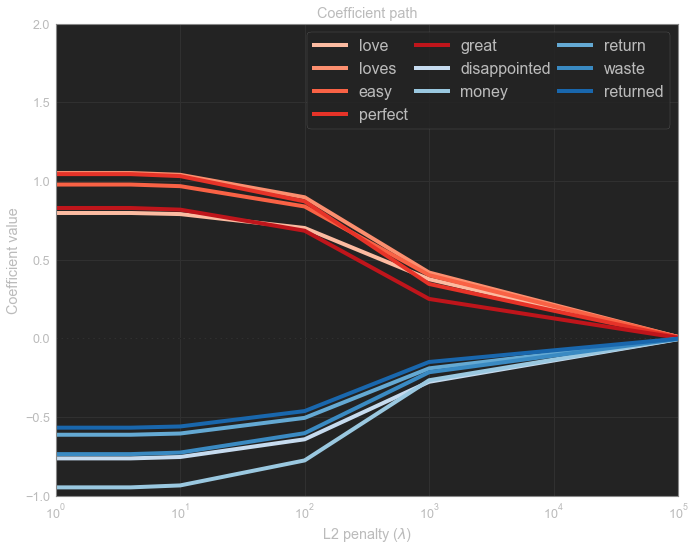

In [94]:
make_coefficient_plot(df, positive_words, negative_words, L2_penalty_list)

### Measuring accuracy
Note: It is important to know that the model prediction code doesn't change even with L2 penalty. The only thing that changes is that the estimated coefficients used in this prediction are different with L2 penalty.

Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data? Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation data? Quiz question: Does the highest accuracy on the training data imply that the model is the best one?

In [127]:
def model_accuaracy(feature_matrix, sentiment, coefficients):
    scores_new = np.dot(feature_matrix, coefficients)
    predictions = np.array([+1 if s > 0 else -1 for s in scores_new]).reshape(len(scores_new), 1)
    num_correct = np.sum(predictions == sentiment)
    accuracy = float(num_correct) / len(feature_matrix)   
    return accuracy

In [128]:
train_acc = []
for i in range(len(L2_penalty_list)):
    train_acc.append(model_accuaracy(feature_matrix_train, sentiment_train, df.iloc[: , i]))

In [133]:
L2_penalty_list

[0, 4, 10, 100.0, 1000.0, 100000.0]

In [129]:
train_acc

[0.7851561577866434,
 0.7851089445480512,
 0.7849909114515711,
 0.7839758268218409,
 0.7758551497839994,
 0.6803663747314747]

In [130]:
valid_acc = []

In [131]:
for i in range(len(L2_penalty_list)):
    valid_acc.append(model_accuaracy(feature_matrix_valid, sentiment_valid, df.iloc[:, i]))

In [132]:
valid_acc

[0.781439641490057,
 0.7815330034543927,
 0.7817197273830642,
 0.781066193632714,
 0.7713565493417982,
 0.667818130893474]